In [129]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from numpy.random import seed
import os
import tempfile
import zipfile
import boto3

from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, LSTM, Dense, GlobalMaxPool1D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from keras.models import Sequential

Load Data

In [47]:
#load data
PATH = os.getcwd()
eth_price = pd.read_csv(f'{PATH}/eth-price.csv')
eth_price = eth_price.drop(["Adj Close", "Date"], axis=1)

#print shape
print("shape of eth price data: " + str(eth_price.shape))
print(eth_price.head)

shape of eth price data: (2235, 5)
<bound method NDFrame.head of              Open         High          Low        Close       Volume
0        2.831620     3.536610     2.521120     2.772120       164329
1        2.793760     2.798810     0.714725     0.753325       674188
2        0.706136     0.879810     0.629191     0.701897       532170
3        0.713989     0.729854     0.636546     0.708448       405283
4        0.708087     1.131410     0.663235     1.067860      1463100
...           ...          ...          ...          ...          ...
2230  3397.422852  3540.807617  3371.892334  3432.018311  15995220233
2231  3433.287842  3448.322021  3286.172363  3329.447998  14257609743
2232  3329.670654  3343.325439  2940.839111  2958.993408  27371684581
2233  2977.310547  3101.697510  2676.407471  2764.431152  30405062665
2234  2763.209229  3089.083008  2741.440674  3077.867920  23742102645

[2235 rows x 5 columns]>


##Data Processing : Training and Testing Data

In [51]:
#round data
def round_data(df):
    name = list(df.columns)
    for col_name in name:
        df[col_name] = df[col_name].round(3)
    return df

#scale data
def scale_data(df, col_name):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    tmp_df = df.copy()
    for i in col_name:
        # rescale values to -1, 1
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled = scaler.fit_transform(tmp_df[i].values.reshape(-1,1))
        scaled = np.reshape(scaled, len(scaled))
        tmp_df[i] = scaled        
    return tmp_df, scaler

#split into training and testing set
def split_train_test(df, train_percentage):
    train_size = int(len(df) * train_percentage)
    train = df[:train_size]
    test = df[train_size:]
    return train, test
    

#build sequence data
def build_multidimension_seqence_data(df, T, D, n_outputs):
    target = df['Close'].values
    N = len(df) - T - n_outputs
    X = np.zeros((N, T, D))
    Y = []

    for t in range(N):
        X[t, :, :] = df[t:t+T]
        y = np.array(target[t+T:t+T+n_outputs])
        Y.append(y)
    Y = np.array(Y)
    
    return X, Y

In [52]:
#split data
train_percentage = 0.8
train_data, test_data = split_train_test(eth_price, train_percentage)
print(len(train_data))
print(len(test_data))
print(train_data.head)
print(test_data.head)

#scaleing traing and testing data
scaled_train, scalers_train = scale_data(train_data, ['Open','High','Low','Volume','Close'])
scaled_test, scalers_test = scale_data(test_data, ['Open','High','Low','Volume','Close'])
print(scaled_train.head)
print(scalers_train)

T = 28 # use T past values to predict the next value
D = pd.DataFrame(scaled_train).shape[1]  # number of feature

n_outputs = 1 # number of forecasting steps

trainX,trainY = build_multidimension_seqence_data(scaled_train,T,D,n_outputs)
testX,testY = build_multidimension_seqence_data(scaled_test,T,D,n_outputs)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)


1788
447
<bound method NDFrame.head of             Open        High         Low       Close      Volume
0       2.831620    3.536610    2.521120    2.772120      164329
1       2.793760    2.798810    0.714725    0.753325      674188
2       0.706136    0.879810    0.629191    0.701897      532170
3       0.713989    0.729854    0.636546    0.708448      405283
4       0.708087    1.131410    0.663235    1.067860     1463100
...          ...         ...         ...         ...         ...
1783  235.702850  236.053406  230.296600  232.944489  7010426122
1784  232.877487  233.901932  229.259460  229.668045  7187490226
1785  229.631485  232.493423  220.564575  222.959793  6918380955
1786  222.914490  228.598282  219.472672  225.347168  6205925718
1787  225.361435  229.903214  222.254990  228.194870  6726164653

[1788 rows x 5 columns]>
<bound method NDFrame.head of              Open         High          Low        Close       Volume
1788   227.968430   229.476807   224.815186   226.31500

##Train LSTM Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 40)                840       
_________________________________________________________________
dropout_4 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 80)                3280      
_________________________________________________________________
dropout_5 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

/Users/huaihsuan/Library/r-miniconda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


110/110 [==============================] - 2s 9ms/step - loss: 0.3614 - val_loss: 0.0223
Epoch 2/50
110/110 [==============================] - 1s 6ms/step - loss: 0.0180 - val_loss: 0.0254
Epoch 3/50
110/110 [==============================] - 1s 6ms/step - loss: 0.0133 - val_loss: 0.0160
Epoch 4/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0133 - val_loss: 0.0322
Epoch 5/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0113 - val_loss: 0.0267
Epoch 6/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0134 - val_loss: 0.0168
Epoch 7/50
110/110 [==============================] - 1s 8ms/step - loss: 0.0134 - val_loss: 0.0466
Epoch 8/50
110/110 [==============================] - 1s 9ms/step - loss: 0.0125 - val_loss: 0.0414
Epoch 9/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0099 - val_loss: 0.0302
Epoch 10/50
110/110 [==============================] - 1s 7ms/step - loss: 0.0106 - val_loss: 0.0335
Epoch 11/5

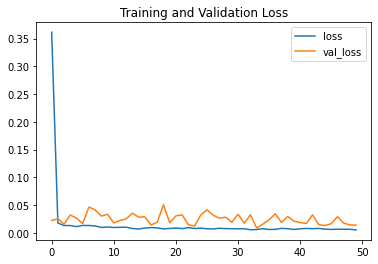

In [54]:
# set seed
seed(100)

# configuting LSTM model
model = Sequential()
model.add(LSTM(units = 20, activation = 'relu', kernel_initializer='normal', input_shape = (T, D)))
model.add(Dropout(0.2))
model.add(Dense(40, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(80, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = n_outputs))
model.summary()

model.compile(
  loss='mse',
  optimizer = Adam(lr= 0.01)
  #optimizer = Adadelta()
)

# train model using first half of the data
r = model.fit(
  trainX, trainY, 
  batch_size=16,
  epochs=50,
  validation_data=(testX, testY)
)

# plot training and validation loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

Model Evaluation : test data

In [97]:
# make forecast using test data
def forecasts(model, testX, T, D):
    forecasts = list()
    for x in testX:
        # make forecast
        forecast = model.predict(x.reshape(1, T, D))
        # store the forecast
        forecasts.append(forecast)
    return forecasts

#inverse scaled data
def scale_inverse(arrays, scaler, n_outputs):
    inverted = list()
    for array in arrays:
        array = array.reshape(-1, n_outputs)
        inv_scale = scaler.inverse_transform(array)
        inverted.append(inv_scale[0,0])
    return inverted

In [111]:
# forecast and evaluate using rmse/ mae
forecast = forecasts(model, testX, T, D)
test_inverted_forecast = scale_inverse(forecast,scalers_test,n_outputs)
test_actual = list(test_data['Close'][T+1:,])

# model evaluation



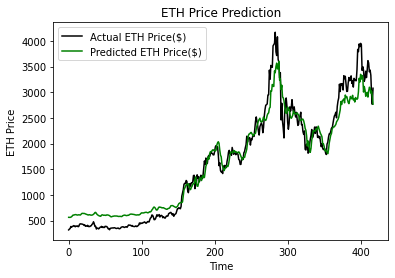

In [114]:
#plotting the graph
plt.plot(test_actual, color = 'black', label = 'Actual ETH Price($)')
plt.plot(test_inverted_forecast, color = 'green', label = 'Predicted ETH Price($)')
plt.title('ETH Price Prediction')
plt.xlabel('Time')
plt.ylabel('ETH Price')
plt.legend()
plt.show()

Save model to aws s3

In [133]:
# save zip file to python temp file

def zipdir(path, ziph):
  # Zipfile hook to zip up model folders
  length = len(path)
  for root, dirs, files in os.walk(path):
    folder = root[length:] # Stop zipping parent folders
    for file in files:
      ziph.write(os.path.join(root, file), os.path.join(folder, file))


# save model to local file
model.save(f"{PATH}/{'coin_price_lstm'}")
# zip the model
zipf = zipfile.ZipFile(f"{PATH}/{'coin_price_lstm'}.zip", "w", zipfile.ZIP_STORED)
zipdir(f"{PATH}//{'coin_price_lstm'}", zipf)
zipf.close()

#upload file to s3
s3 = boto3.client('s3', aws_access_key_id='',
                      aws_secret_access_key='')

s3.upload_file('coin_price_lstm.zip', 'eth-price', 'coin_price_lstm.zip')
print("Upload Successful")


  

INFO:tensorflow:Assets written to: /Users/huaihsuan/Desktop/Projects/coin prediction/coin_price_lstm/assets
